# COMP2002 Assessment

This notebook will contain demonstrations of:
- Regression models trained to predict the Fire Weather Index (FWI) at a given time based on 12 numerical inputs from records of forest fires in 2 regions of Algeria.
- Optimisers designed to optimise routes between cities in the Travelling Salesman Problem.

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

### Regression

In [2]:
# Load forest file data using Pandas
forest_fire_region_1_data = pd.read_csv("./data/AlgerianFF_Region1.csv")
forest_fire_region_2_data = pd.read_csv("./data/AlgerianFF_Region2.csv")

In [3]:
# Copy data to avoid making permanent unrecoverable changes to the original
forest_fire_region_1_training_data = forest_fire_region_1_data.copy()
forest_fire_region_2_training_data = forest_fire_region_2_data.copy()

# Seperate FWI from the rest of the data, as this is the output we want to generate
forest_fire_region_1_training_targets = forest_fire_region_1_training_data.pop("FWI")
forest_fire_region_2_training_targets = forest_fire_region_2_training_data.pop("FWI")

In [4]:
# Create separate scalers for each dataset
ffr_1_scaler = MinMaxScaler()
ffr_2_scaler = MinMaxScaler()

# Fit each scaler on its own dataset
ffr_1_scaler.partial_fit(forest_fire_region_1_training_data)
ffr_1_scaler.partial_fit(forest_fire_region_2_training_data)

# Normalise each dataset using the now fitted scalers
scaled_ffr_1_training_data = ffr_1_scaler.transform(forest_fire_region_1_training_data)
scaled_ffr_2_training_data = ffr_1_scaler.transform(forest_fire_region_2_training_data)
print(scaled_ffr_1_training_data.ptp(axis=0))
print(scaled_ffr_2_training_data.ptp(axis=0))

[1.         1.         0.         0.75       0.63768116 0.65217391
 1.         0.91543027 0.82055215 1.         0.65789474 0.99103139]
[1.         1.         0.         0.9        1.         1.
 0.51785714 0.8620178  0.99693252 0.79625293 0.99473684 0.9955157 ]


In [5]:
# Initialise regressor objects
random_forest_regressor = RandomForestRegressor(n_estimators=100)
# Set activaion to tanh and solver to lbfgs for better performance on smaller datasets
neural_network_regressor = MLPRegressor(solver='lbfgs', activation='tanh')
# Set kernel to linear for better performance
support_vector_regressor = SVR(kernel='linear', C=6.0)

In [6]:
# Train regressors on training data
random_forest_regressor.fit(scaled_ffr_1_training_data, forest_fire_region_1_training_targets)
neural_network_regressor.fit(scaled_ffr_1_training_data, forest_fire_region_1_training_targets)
support_vector_regressor.fit(scaled_ffr_1_training_data, forest_fire_region_1_training_targets)

SVR(C=6.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [7]:
def test_on_point_in_dataset(regressor, point_index):
    prediction = regressor.predict(scaled_ffr_1_training_data[point_index].reshape(1, 12))
    prediction_string = f"Real: {forest_fire_region_1_training_targets[point_index]}\nPredicted by regressor: {prediction[0]}"
    return prediction_string

In [8]:
# Use trained random forest regressor to predict the first point in the training dataset
print(test_on_point_in_dataset(random_forest_regressor, 0))

Real: 0.5
Predicted by regressor: 0.521


In [9]:
# Use trained neural network regressor to predict the first point in the training dataset
print(test_on_point_in_dataset(neural_network_regressor, 0))

Real: 0.5
Predicted by regressor: 0.5741046798906451


In [10]:
# Use trained support vector regressor to predict the first point in the training dataset
print(test_on_point_in_dataset(support_vector_regressor, 0))

Real: 0.5
Predicted by regressor: 0.40019701075236347


In [11]:
def get_mae_from_testing_data(regressor, testing_data, testing_targets):
    predictions = regressor.predict(testing_data)
    return mean_absolute_error(testing_targets, predictions)

In [12]:
def plot_mae_data(mae_data):
    # Create list of labels and colours for plotting
    labels = ["Random Forest Regressor", "Neural Network Regressor", "Support Vector Regressor"]
    colors = ["blue", "red", "green"]

    # Alter figsize to avoid overlapping tick labels
    plt.figure(figsize=(9.6, 7.2))
    plt.bar([0, 1, 2], mae_data, color=colors, tick_label=labels)
    plt.ylabel("Mean Absolute Error rate")
    plt.show()

[1.1295819672131147, 0.46773129987126666, 0.6680912805030614]


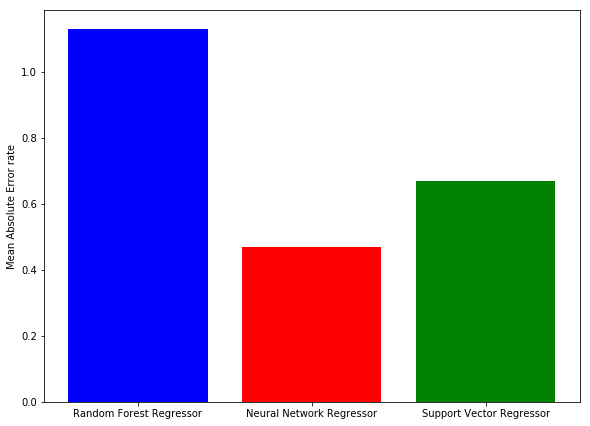

In [13]:
rf_mae = get_mae_from_testing_data(random_forest_regressor, scaled_ffr_2_training_data, forest_fire_region_2_training_targets)
nn_mae = get_mae_from_testing_data(neural_network_regressor, scaled_ffr_2_training_data, forest_fire_region_2_training_targets)
sv_mae = get_mae_from_testing_data(support_vector_regressor, scaled_ffr_2_training_data, forest_fire_region_2_training_targets)

mae_data = [rf_mae, nn_mae, sv_mae]
print(mae_data)
plot_mae_data(mae_data)

In [14]:
def get_cross_validation_scores(regressor, testing_data, testing_targets):
    return cross_val_score(regressor, testing_data, testing_targets, cv=5)

In [15]:
def plot_cross_validation(cross_validation_data):
    # Set up labels
    regressor_labels = ["Random Forest Regressor", "Neural Network Regressor", "Support Vector Regressor"]
    # Set figsize to avoid labels overlapping
    plt.figure(figsize=(9.6, 7.2))
    # Plot data with labels
    plt.boxplot(cross_validation_data, labels=regressor_labels)
    plt.hlines(1, 0, 4, label="Best possible score")
    
    
    plt.show()

In [16]:
random_forest_scores = get_cross_validation_scores(random_forest_regressor, scaled_ffr_2_training_data, forest_fire_region_2_training_targets)
neural_network_scores = get_cross_validation_scores(neural_network_regressor, scaled_ffr_2_training_data, forest_fire_region_2_training_targets)
support_vector_scores = get_cross_validation_scores(support_vector_regressor, scaled_ffr_2_training_data, forest_fire_region_2_training_targets)

[0.98325174 0.94626164 0.94499235 0.87966744 0.9811552 ] [0.95568217 0.98772879 0.90786531 0.99356261 0.9626411 ] [0.96533053 0.99450886 0.87582752 0.97236218 0.98179134]


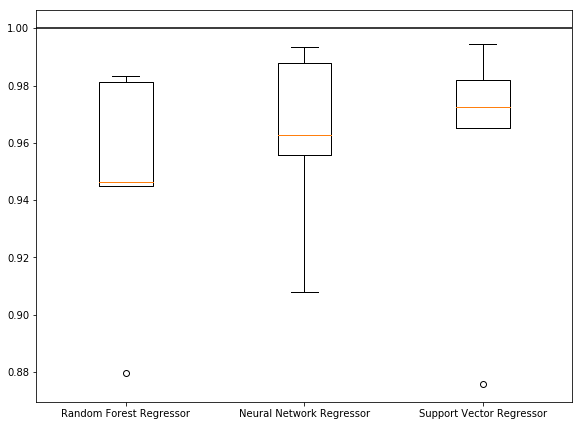

In [17]:
print(random_forest_scores, neural_network_scores, support_vector_scores)
plot_cross_validation((random_forest_scores, neural_network_scores, support_vector_scores))

### Optimisation

In [5]:
def get_total_distance_of_route(route, distance_data):
    total_distance = 0
    for city_index in range(0, len(route) - 1):
        city_from = route[city_index]
        city_to = route[city_index + 1]
        single_distance = distance_data[city_from][city_to]
        total_distance += single_distance
    
    return total_distance

In [6]:
def get_distance_data():
    with open("./data/cities.txt") as cities_long_file:
        # Read and use splitlines rather than readlines to avoid \n characters on the end of city names
        cities_long = cities_long_file.read().splitlines()
        # Read CSV and specify seperator in order to use faster C implementation of CSV reader
        distance_long = pd.read_csv("./data/distances.csv", sep=",", names=cities_long)
        # Set index names seperately as this is not an option in the read_csv method
        distance_long.index = cities_long
    with open("./data/cities_short.txt") as cities_short_file:
        cities_short = cities_short_file.read().splitlines()
        distance_short = pd.read_csv("./data/distances_short.csv", sep=",", names=cities_short)
        distance_short.index = cities_short
    
    return (cities_long, distance_long, cities_short, distance_short)

In [7]:
cities_long, distance_long, cities_short, distance_short = get_distance_data()

default_long_distance = get_total_distance_of_route(cities_long, distance_long)
default_short_distance = get_total_distance_of_route(cities_short, distance_short)
print(default_long_distance)
print(default_short_distance)

3037.4999999999995
1133
